In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt

## Notes

MADDPG[https://papers.nips.cc/paper/2017/file/68a9750337a418a86fe06c1991a1d64c-Paper.pdf] a **centralized critic** and decentralized actors. Since the training of each agent is conditioned on the observation and action of all the other agents, each agent perceives the environment as stationary.

Q-learning challenged by non-stationrity via NO replay memory.

Policy gradient methods suffer from variance in estimates as the number of agents increases.

Model free.

Applicable to both cooperative and competitive.

Learns a centralized critic for each agent, allowing for agents with differing reward functions.

Considers envs with comm between agents (can work but not necessary).

Requires explicitly modeling decision-making process of other agents. 

Show that probability of taking a correct-direction gradient-step decreases exp. with the number of agents. (Proof in appendix). 

Learned policies can only use local information at execution time. 

Given $N$ agents parameterized by $\theta = \{\theta_i\}_{i=1}^N$, let $\pi = \{\pi_i\}_{i=1}^N$ be a set of all agent policies. Then, the gradient of the expected return for agent $i$, $J(\theta_i) = \mathbb{E}[R_i]$ is :

$$
\nabla_{\theta_i}J(\theta_i) = \mathbb{E}_{s \sim p^{\mu},a_i \sim \pi_i}[\nabla_{\theta_i}log \pi_i (a_i|o_i)Q^{\pi}_i(x,a_1,...,a_N)]
$$
where $x$ is some state-based information such as $x=(o_1,...,o_N)$. 

If we know the actions of all other agents, the environment is stationary, even as policies change. To remove this assumption, each agent $i$ can additionally maintain an approximation of the policy $\hat{\mu}_i^j$ of other agents $j$. This approx policy is learned by maximizing the log prob of agent $j's$ actions, with an entropy regularizer:

$$
\mathcal{L}(\phi^j_i) = -\mathbb{E}_{o_j,a_j}[log \hat{\mu}^j_i(a_j|o_j) + \lambda H(\hat{\mu}_i^j)]
$$
which can trivially be extended to approximate Q-functions.

Can also train $K$ sub-policies for each agent as a method to improve robustness vs. competitors.

ENVS:

**Cooperative navigation**: agents must cooperate to reach $L$ landmarks. Observation are relative positions of other agents and landmarks and agents are collectively rewarded based on proximity of any agent to each landmark. Penalties for touching each other. No communication.

- 3 agents

### Env

Envs return: [obs, reward, done, info IF BENCHMARK]

In [2]:
from multiagent.environment import MultiAgentEnv
import multiagent.scenarios as scenarios

In [3]:
# "simple_spread" is cooperative navigation
scenario = scenarios.load('simple_spread' + ".py").Scenario()
world = scenario.make_world()
env = MultiAgentEnv(world, scenario.reset_world, scenario.reward, 
                    scenario.observation, scenario.benchmark_data)

In [4]:
env.agents

In [5]:
env.observation_space

[Box(-inf, inf, (18,), float32),
 Box(-inf, inf, (18,), float32),
 Box(-inf, inf, (18,), float32)]

In [6]:
env.action_space

[Discrete(5), Discrete(5), Discrete(5)]

In [7]:
env.reset()

[array([ 0.        ,  0.        ,  0.94135368, -0.32472144, -0.20875832,
         1.08482044, -0.56750365, -0.64662086, -0.18602154, -0.33859685,
        -1.5183492 , -0.35639664,  0.00743289,  0.30012282,  0.        ,
         0.        ,  0.        ,  0.        ]),
 array([ 0.        ,  0.        , -0.57699552, -0.68111807,  1.30959087,
         1.44121708,  0.95084554, -0.29022422,  1.33232765,  0.01779978,
         1.5183492 ,  0.35639664,  1.52578209,  0.65651946,  0.        ,
         0.        ,  0.        ,  0.        ]),
 array([ 0.        ,  0.        ,  0.94878657, -0.02459861, -0.21619121,
         0.78469762, -0.57493654, -0.94674368, -0.19345443, -0.63871968,
        -0.00743289, -0.30012282, -1.52578209, -0.65651946,  0.        ,
         0.        ,  0.        ,  0.        ])]

get action

action_n = [agent.action(obs) for agent, obs in zip(trainers,obs_n)]

environment step

new_obs_n, rew_n, done_n, info_n = env.step(action_n)

### Components

In [8]:
def onehot_from_logits(logits, eps=0.0):
    """
    Given batch of logits, return one-hot sample using epsilon greedy strategy
    (based on given epsilon)
    """
    # get best (according to current policy) actions in one-hot form
    argmax_acs = (logits == logits.max(-1, keepdim=True)[0]).float()
    return argmax_acs


In [9]:
class ReplayMemory:
    def __init__(self, capacity, obs_shape, action_shape, device):
        self.capacity = capacity
        self.obs = np.empty((capacity, *obs_shape), dtype=np.float32)
        self.obs_next = np.empty((capacity, *obs_shape), dtype=np.float32)
        self.actions = np.empty((capacity, *action_shape), dtype=np.float32)
        self.rewards = np.empty((capacity, 1), dtype=np.float32)
        self.not_dones = np.empty((capacity, 1), dtype=np.float32)
        
        self.device = device
        
        self.idx = 0
        self.full = False
    
    def __len__(self):
        return self.idx if not self.full else self.capacity
    
    def add(self, obs, actions, rewards, obs_next, not_done):
        np.copyto(self.obs[self.idx], obs)
        np.copyto(self.actions[self.idx], actions)
        np.copyto(self.rewards[self.idx], rewards)
        np.copyto(self.obs_next[self.idx], obs_next)
        np.copyto(self.not_dones[self.idx], not_done)
        
        self.idx = (self.idx + 1) % self.capacity
        self.full = self.full or self.idx == 0
        
    def sample(self, batch_size):
        idxs = np.random.randint(0,
                                 self.capacity if self.full else self.idx,
                                 size=batch_size)

        obs = self.obs[idxs]
        obs_next = self.obs_next[idxs]
        
        obs = torch.as_tensor(obs, device=self.device).float()
        obs_next = torch.as_tensor(obs_next, device=self.device).float()
        
        actions = torch.as_tensor(self.actions[idxs], device=self.device)
        rewards = torch.as_tensor(self.rewards[idxs], device=self.device)
        
        not_dones = torch.as_tensor(self.not_dones[idxs], device=self.device)
        
        return obs, actions, rewards, obs_next, not_dones

In [10]:
class Critic(nn.Module):
    """MADDPG critic takes a concatenation of all agent's local obs
        Action-value function
    """
    def __init__(self, obs_shape, action_shape, hidden_dim, n_layers):
        super().__init__()
        
        inp_shape = obs_shape + action_shape[0] * action_shape[1]
        
        self.net = nn.ModuleList([nn.Linear(inp_shape, hidden_dim), 
                                  nn.ReLU()])
        
        for _ in range(n_layers - 2):
            self.net.append(nn.Linear(hidden_dim, hidden_dim))
            self.net.append(nn.ReLU())
            
        self.net.append(nn.Linear(hidden_dim, 1))
        
    def forward(self, o, a):
        x = torch.cat([o, a], dim=-1)
        for layer in self.net:
            x = layer(x)
        return x

In [11]:
class Actor(nn.Module):
    def __init__(self, obs_shape, action_shape, hidden_dim, n_layers):
        super().__init__()
        
        
        self.net = nn.ModuleList([nn.Linear(obs_shape, hidden_dim), nn.ReLU()])
        
        for _ in range(n_layers - 2):
            self.net.append(nn.Linear(hidden_dim, hidden_dim))
            self.net.append(nn.ReLU())
        
        self.net.append(nn.Linear(hidden_dim, action_shape[1]))
        
    def forward(self, o):
        for layer in self.net:
            o = layer(o)
        return o

In [12]:
class MADDPG:
    """lr=1e-2, tau=1e-2, gamma=0.95, mem_size=1e6"""
    def __init__(self, obs_shape, action_shape, n_agents, batch_size,
                 hidden_dim, n_layers, lr, tau, gamma, mem_capacity, device):
        
        self.actors = []
        for _ in range(n_agents):
            self.actors.append(Actor(
                obs_shape[1], action_shape, hidden_dim, n_layers
            ).to(device))
            
        self.actor_targets = []
        for _ in range(n_agents):
            self.actor_targets.append(Actor(
                obs_shape[1], action_shape, hidden_dim, n_layers
            ).to(device))
        
        self.critic = Critic(
            obs_shape[0] * obs_shape[1], action_shape * n_agents, hidden_dim, n_layers
        ).to(device)
        
        self.critic_target = Critic(
            obs_shape[0] * obs_shape[1], action_shape * n_agents, hidden_dim, n_layers
        ).to(device)
        
        self.critic_target.load_state_dict(self.critic.state_dict())
        
        for i in range(n_agents):
            self.actor_targets[i].load_state_dict(self.actors[i].state_dict())
        
        self.actor_optims = []
        for i in range(n_agents):
            self.actor_optims.append(Adam(self.actors[i].parameters(), lr=lr))
            
        self.critic_optim = Adam(self.critic.parameters(), lr=lr)
        
        self.memory = ReplayMemory(mem_capacity, obs_shape, action_shape, device)
        
        self.gamma = gamma
        self.obs_shape = obs_shape
        self.obs_shape_flat = obs_shape[0] * obs_shape[1]
        self.action_shape_flat = action_shape[0] * action_shape[1]
        self.batch_size = batch_size
        self.n_agents = n_agents
        self.tau = tau
        
    def act(self, obs, sample=True):
        actions = []
        for i, actor in enumerate(self.actors):
            with torch.no_grad():
                logits = actor(obs[i])
            
            if sample:
                actions.append(F.gumbel_softmax(logits).cpu().numpy())
            else:
                # this currently returns [0, 1, 0]...
                actions.append(onehot_from_logits(logits))
        return actions
                
    def update(self):
        if len(self.memory) < self.batch_size:
            return
        
        for j in range(self.n_agents):
            obs, actions, rewards, obs_next, not_dones = self.memory.sample(self.batch_size)
            self.update_critic(obs, actions, rewards, obs_next, not_dones)
            self.update_actor(obs, j)
            
        self.soft_update()
    
    def update_critic(self, obs, actions, rewards, obs_next , not_dones):
        """
            obs = obs.view(self.batch_size, self.obs_shape * self.n_agents)
            obs_next = obs_next.view(self.batch_size, self.obs_shape * self.n_agents)
        """
        with torch.no_grad():
            next_actions = []
            for i, actor in enumerate(self.actor_targets):
                # [whole batch, agent i, whole obs]
                logits = actor(obs_next[:, i, :])
                next_actions.append(onehot_from_logits(logits))
                
            # Stacking the list together...
            # [[0,1,0, ..., 1,0,0], ..., [0,1,0, ..., 1,0,0]]
            next_actions = torch.stack(next_actions, dim=1).view(self.batch_size,
                                                                 self.action_shape_flat)
            
            obs_next_reshape = obs_next.view(self.batch_size, self.obs_shape_flat)
            
            q_target = rewards + not_dones * self.gamma * self.critic_target(obs_next_reshape,
                                                                             next_actions)
            
        obs_reshape = obs.view(self.batch_size, self.obs_shape_flat)
        q_value = self.critic(obs_reshape, actions.view(self.batch_size, self.action_shape_flat))
        
        self.critic_optim.zero_grad()
        critic_loss = F.mse_loss(q_value, q_target)
        critic_loss.backward()
        self.critic_optim.step()
        
    
    def update_actor(self, obs, j):
        """
        dist = self.actor(obs, detach_encoder=True)
        action = dist.rsample()
        log_prob = dist.log_prob(action).sum(-1, keepdim=True)
        # detach conv filters, so we don't update them with the actor loss
        actor_Q1, actor_Q2 = self.critic(obs, action, detach_encoder=True)

        actor_Q = torch.min(actor_Q1, actor_Q2)

        actor_loss = (self.alpha.detach() * log_prob - actor_Q).mean()
        """
        actions = []
        pis = []
        
        # Shape of actions = [batch, n_agents, n_actions]
        # [:, i, :] for actions from ith agent
        for i, actor in enumerate(self.actors):
            logits = actor(obs[:, i, :])
            pis.append(logits)
            actions.append(F.gumbel_softmax(logits, hard=True))
        
        # This process may not be necessary...
        for i in range(len(actions)):
            if i == j:
                continue
            else:
                actions[i].detach()
                pis[i].detach()

        actions = torch.stack(actions, dim=1).view(self.batch_size,
                                                   self.action_shape_flat)
        reshaped_obs = obs.view(self.batch_size, self.obs_shape_flat)
        pi_loss = -self.critic(reshaped_obs, actions).mean()

        self.actor_optims[j].zero_grad()
        pi_loss.backward()
        self.actor_optims[j].step()  
    
    def soft_update(self):
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(target_param.data * (1. - self.tau) + param.data * self.tau)
            
        for i in range(self.n_agents):
            for target_param, param, in zip(self.actor_targets[i].parameters(), self.actors[i].parameters()):
                target_param.data.copy_(target_param.data * (1. - self.tau) + param.data * self.tau)

In [535]:
learner = MADDPG(
    obs_shape=np.array(env.reset()).shape, action_shape=[3, 5], n_agents=3, 
    batch_size=1024, hidden_dim=64, n_layers=2, lr=0.01, tau=0.01, 
    gamma=0.95, mem_capacity=int(1e6), device='cpu'
)

In [19]:
RUNS = 5
EPISODE_LENGTH = 25
device = 'cpu'

outer_rewards = []

for _ in range(RUNS):
    learner = MADDPG(
        obs_shape=np.array(env.reset()).shape, action_shape=[3, 5], n_agents=3, 
        batch_size=1024, hidden_dim=128, n_layers=2, lr=0.01, tau=0.01, 
        gamma=0.95, mem_capacity=int(1e6), device=device
    )
    
    EPISODES = 10000

    reward_hist = []

    for e in tqdm(range(EPISODES)):
        obs = env.reset()
        done = False
        not_done = 1
        steps = 0
        episode_rewards = 0

        while not done:
            actions = learner.act(torch.tensor(obs).float().to(device))
            actions = np.array(actions)
            obs_next, rewards, dones, info = env.step(actions)
            episode_rewards += rewards[0]
            steps += 1

            if steps == EPISODE_LENGTH:
                not_done = 0
                done = True

            learner.memory.add(obs, actions, rewards[0], obs_next, not_done)

            learner.update()

            obs = obs_next

        reward_hist.append(episode_rewards)
        
    outer_rewards.append(reward_hist)

100%|██████████| 10000/10000 [1:54:11<00:00,  1.46it/s]


In [23]:
smoothed = []

for run in outer_rewards:
    inner = []
    b_idx = 0
    e_idx = 100
    while e_idx < len(run):
        inner.append(np.mean(run[b_idx: e_idx]))
        b_idx += 1
        e_idx += 1
        
    smoothed.append(inner)

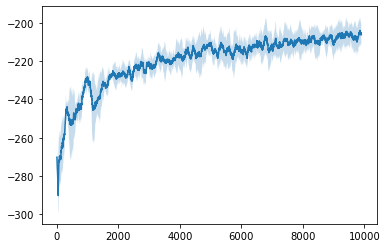

In [24]:
plt.plot(np.mean(np.array(smoothed), axis=0))

plt.fill_between(
    range(len(smoothed[0])),
    np.mean(np.array(smoothed), axis=0) + np.std(np.array(smoothed), axis=0),
    np.mean(np.array(smoothed), axis=0) - np.std(np.array(smoothed), axis=0),
    alpha=0.25
)